## 6.9 因果推論(2) 回帰非連続デザイン(RDD)

Evan Magnusson氏によるRDDパッケージとそのチュートリアル．
https://github.com/evan-magnusson/rdd
https://github.com/evan-magnusson/rdd/blob/master/tutorial/tutorial.ipynb

RDDでば，特定の政策や施策が実行されたことによる効果が存在するか否かについて推定することができる．

以下は，上記チュートリアルからコピーしたものです．若干変更を加えています．
詳細は，教科書を参照してください．

In this brief tutorial, we will go through how to implement a simple regression discontinuity design, using the functions in the `rdd` package.

In [1]:
# rddパッケージがインストールされていないなら，以下でインストールする．
!pip install rdd

  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4719 sha256=31057a1d0e1959f46521c4cb845ac4a41cbdf057a5259870f682210fc992ac25
  Stored in directory: c:\users\murakawa\appdata\local\pip\cache\wheels\4b\c6\1d\859e785cf16b1f9d5cba3cda9943cadd8b252f41fb2e7a642e
Successfully built rdd


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdd import rdd

# Generate Some Data

First, let's generate a dataset to work with.

In [3]:
np.random.seed(42)

In [6]:
#サンプルサイズ
N = 10000
x = np.random.normal(1, 1, N)
epsilon = np.random.normal(0, 1, N)
#しきい値
threshold = 1
treatment = np.where(x >= threshold, 1, 0)
w1 = np.random.normal(0, 1, N)
w2 = np.random.normal(0, 4, N)
#y = .5 * treatment + 2 * x - .2 * w1 + 1 + epsilon
y = .7 * treatment + 4 * x - .3 * w1 + 1 + epsilon

data = pd.DataFrame({'y':y, 'x': x, 'w1':w1, 'w2':w2})
data.head()

,y,x,w1,w2
0,3.187125,0.528142,0.078838,1.280610
1,9.517832,2.012702,0.562897,4.461846
2,5.056713,0.801813,0.341102,-6.020953
3,7.978482,1.090569,-1.277914,6.958423
4,9.312275,1.717391,-0.186220,1.320347


# Restrict Data

When running our RDD, we first want to choose a bandwidth that we will use to restrict our dataset to only analyze observations that are very close to the threshold.  We can pick whatever bandwidth we like, or we can select the optimal bandwidth.

We do this by giving `optimal_bandwidth()` our outcome variable, the running variable, and the threshold in the running variable.

In [7]:
#帯域幅(bandwidth)を設定
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 1.1099936525615817


Now let's restrict the dataset to be only observations within this bandwidth of the threshold. 

(Note: `truncated_data()` can also call `optimal_bandwidth()`, which saves you a step)

In [8]:
#帯域幅としきい値を用いて，観察対象とするデータ部分のみを取り出す
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)

# Check for the Presence of a Discontinuity

Before we move to estimation, let's see if graphically it even looks like there is a discontinuous change in the outcome at the threshold.  We use a regular scatter plot.

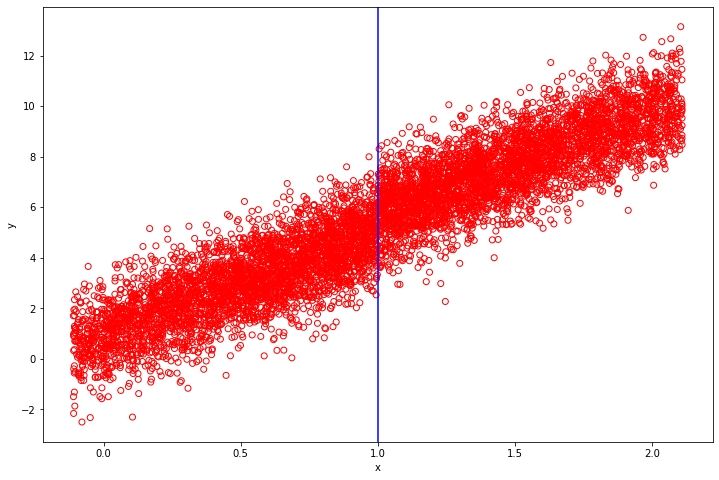

In [9]:
#取り出したデータから，xとyの散布図を描画する
plt.figure(figsize=(12, 8))
plt.scatter(data_rdd['x'], data_rdd['y'], facecolors='none', edgecolors='r')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(x=threshold, color='b')
plt.show()
plt.close()

As you can see, it's really hard to tell what's going on at the threshold - it's far to noisy.  So what we'll do is put the data into bins based on the running variable, get the average value of the outcome variable in each bin, then plot the result.  This will allow us to parse through the noise.

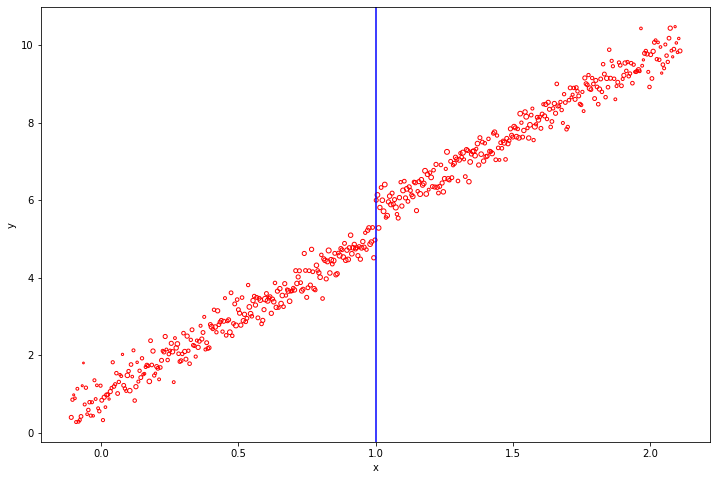

In [11]:
#data_binned = rdd.bin_data(data_rdd, 'y', 'x', 100)
data_binned = rdd.bin_data(data_rdd, 'y', 'x', 500)

plt.figure(figsize=(12, 8))
plt.scatter(data_binned['x'], data_binned['y'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='r')
plt.axvline(x=threshold, color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.close()

That's better - it's much easier to see discontinuity now. When we run our estimation, it should be easy to detect this.  If we didn't see any change in the plot, but did find a treatment effect in our estimation (or vice versa), we might be worried.

Why do we weight by the number of observations in each bin?  The number of observations is not equal across bins, and this can help inform the results we get from our estimation in the next step.

# Estimation

Now the fun part.  All we have to do is estimate a simple linear regression of the outcome variable on a dummy variable for whether the observations lies to the right or left of the variable (which we'll call `TREATED`), and the running variable.  We could do this ourselves, but we can also run `rdd()`.  The output will be a Statsmodels linear regression object, which we can then fit and display results for.

(Note: While weighted least squares is used, the default weights are 1, resulting in OLS by default.)

In [12]:
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            WLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 2.323e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:03:18   Log-Likelihood:                -10778.
No. Observations:                7317   AIC:                         2.156e+04
Df Residuals:                    7314   BIC:                         2.158e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

It looks pretty good! We're getting a treatment effect that is pretty close to the actual treatment effect (even though we've omitted a variable).

We can also add controls, change the covariance structure, specify our own equation, or run weighted least squares.

In [13]:
model = rdd.rdd(data_rdd, 'x', 'y', cut=threshold, controls=['w1', 'w2'])
print(model.fit(cov_type='hc1').summary())

Estimation Equation:	 y ~ TREATED + x + w1 + w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            WLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 1.256e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:03:32   Log-Likelihood:                -10467.
No. Observations:                7317   AIC:                         2.094e+04
Df Residuals:                    7312   BIC:                         2.098e+04
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [14]:
model = rdd.rdd(data_rdd, 'x', cut=threshold, equation='y ~ TREATED + x + w1*w2')
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1*w2
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            WLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 1.024e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:03:35   Log-Likelihood:                -10467.
No. Observations:                7317   AIC:                         2.095e+04
Df Residuals:                    7311   BIC:                         2.099e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

# Validation: Placebo Tests

How can we check to see if our results are robust?  One method is to repeat the analysis, using a fake threshold.  This placebo test should result in a null treatment effect -- since the threshold is fake, nothing is inherently different for observations on either side.  If we do still see a statistially significant coefficient on `TREATED`, that may be cause for alarm.

Let's put a fake threshold at 0, and test for the causal effect there.

In [15]:
data_placebo = rdd.truncated_data(data, 'x', yname='y', cut=0)

In [16]:
model = rdd.rdd(data_placebo, 'x', 'y', cut=0, controls=['w1'])
print(model.fit().summary())

Estimation Equation:	 y ~ TREATED + x + w1
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.707
Model:                            WLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     2768.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:03:47   Log-Likelihood:                -4895.4
No. Observations:                3441   AIC:                             9799.
Df Residuals:                    3437   BIC:                             9823.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

There's no statistical effect!  Excellent.